In [52]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import pickle

import numpy as np

In [2]:
with open('../data/CIFAR10/batches.meta', 'rb') as f:
    meta = pickle.load(f)
    
class_names = dict(zip(list(range(10)), meta['label_names']))

In [3]:
transform_list = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1,)),
])

train = datasets.CIFAR10('../data/CIFAR10/train', train=True, download=True, transform=transform_list)
test = datasets.CIFAR10('../data/CIFAR10/test', train=False, download=True, transform=transform_list)

Files already downloaded and verified
Files already downloaded and verified


In [44]:
trainset = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

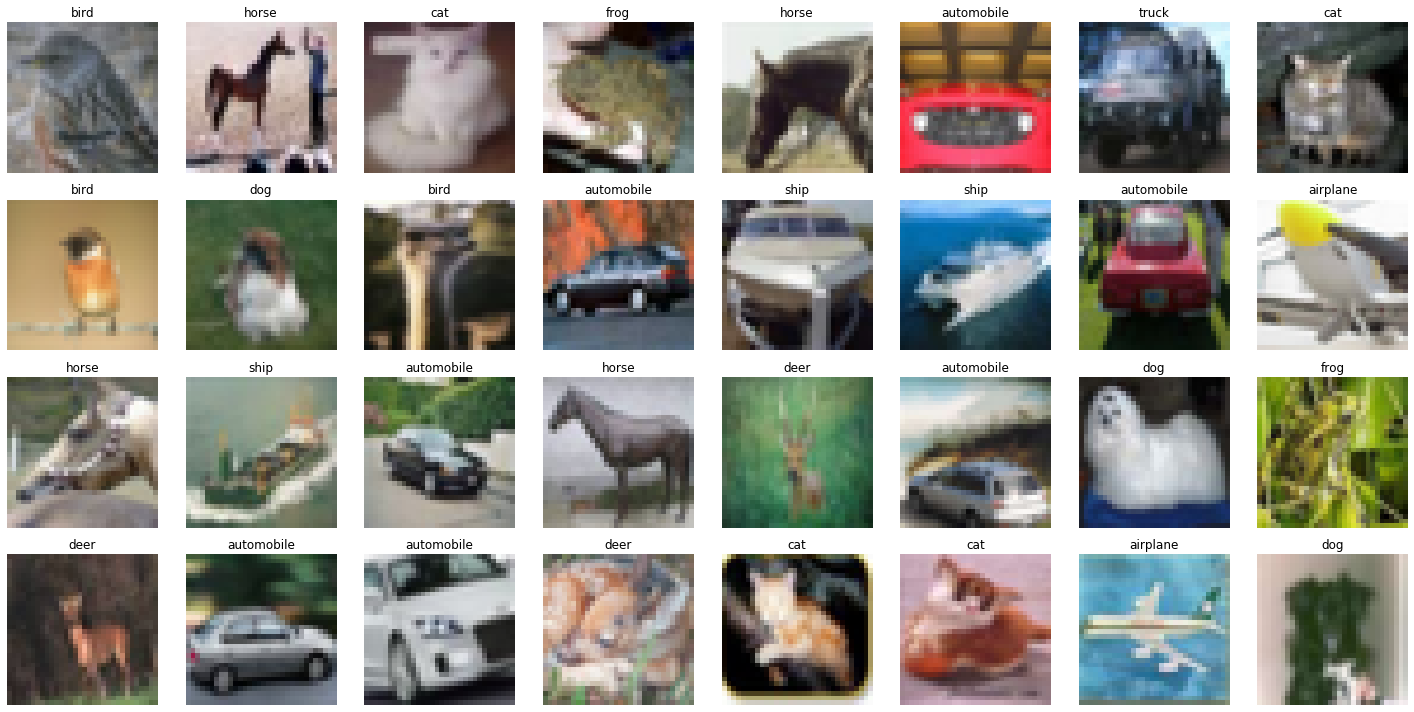

In [45]:
batch, labels = next(iter(trainset))

f = plt.figure(figsize=(20, 10))

n_rows = 8
n_cols = 4

for i in range(n_cols*n_rows):
    ax = f.add_subplot(n_cols, n_rows, i+1)
    ax.axis('off')
    plt.imshow(batch[i].permute(1,2,0)+.5)
    plt.title(class_names[int(labels[i])])
    
plt.tight_layout()

In [110]:
def conv_block(in_ch, inner_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, inner_ch, kernel_size=(3, 3), padding=1),
        nn.LeakyReLU(.1),
        nn.Conv2d(inner_ch, out_ch, kernel_size=(3, 3), padding=1),
        nn.LeakyReLU(.1),
        nn.MaxPool2d(2, 2),
        nn.Dropout2d(.25)
    )

def fc_block(in_f, inner_f, *args, **kwargs):
    return nn.Sequential(
        nn.Linear(in_f, inner_f),
        nn.LeakyReLU(.1),
        nn.Dropout(0.5),
        nn.Linear(inner_f, 10),
        nn.Softmax(dim=1)
    )


class Model(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        self.conv1 = conv_block(3, 16, 32)
        self.conv2 = conv_block(32, 32, 64)
        '''for l in self.conv2:
            if l is nn.Conv2d:
                print('conv')
                nn.init.kaiming_uniform_(l.weights)'''
        
        self.fc = fc_block(64*8*8, 256)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = x.view(-1, 64*8*8)
        
        x = self.fc(x)
        
        return x

In [111]:
def evaluate_accuracy_and_loss(model, testset):
    '''
    Evaluates both model accuracy and loss on a given dataset
    
    model - model to evaluate
    testset - dataset to evaluate model on
    
    Returns tuple (accuracy, mean loss)
    '''
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in testset:
            images, labels = batch
            output = model(images.cuda())            
            for idx, i in enumerate(output):
                if torch.argmax(i) == labels[idx]:
                    correct += 1
                total += 1
                
    return correct/total

In [113]:
model = Model().cuda()
epochs = 10

optimizer = optim.Adamax(model.parameters(), lr=5e-3)
criterion = nn.CrossEntropyLoss()

for e in range(epochs):
    print('Epoch: %s' % str(e+1))
    
    model.train()
    for param_group in optimizer.param_groups:
        param_group['lr'] = 5e-3*0.9**e
    
    for i, (batch, labels) in enumerate(trainset):
        
        optimizer.zero_grad()
        output = model(batch.cuda())
        
        loss = criterion(output, labels.cuda())*128
        loss.backward()
        
        optimizer.step()
        
        if i % 100 == 0:
            print('Loss: %.2f' % loss)
        
    else:
        model.eval()
        print('Accuracy: %.3f' % evaluate_accuracy_and_loss(model, testset))

Epoch: 1
Loss: 294.72
Loss: 280.39
Loss: 264.65
Loss: 258.19
Accuracy: 0.424
Epoch: 2
Loss: 267.94
Loss: 261.17
Loss: 266.58
Loss: 258.20
Accuracy: 0.472
Epoch: 3
Loss: 249.45
Loss: 248.61
Loss: 261.05
Loss: 253.98
Accuracy: 0.515
Epoch: 4
Loss: 253.35
Loss: 250.07
Loss: 260.02
Loss: 248.85
Accuracy: 0.544
Epoch: 5
Loss: 246.90
Loss: 238.66
Loss: 243.76
Loss: 242.84
Accuracy: 0.566
Epoch: 6
Loss: 238.65
Loss: 250.54
Loss: 249.72
Loss: 239.99
Accuracy: 0.583
Epoch: 7
Loss: 242.56
Loss: 241.77
Loss: 241.44
Loss: 237.50
Accuracy: 0.600
Epoch: 8
Loss: 238.44
Loss: 243.43
Loss: 233.77
Loss: 241.29
Accuracy: 0.613
Epoch: 9
Loss: 237.18
Loss: 238.65
Loss: 238.76
Loss: 240.98
Accuracy: 0.622
Epoch: 10
Loss: 241.38
Loss: 232.82
Loss: 233.36
Loss: 224.26
Accuracy: 0.641
